# Biomedical literature annotations

This {{ "[repository]({})".format(repo_url) }} stores manual annotations (a.k.a tagging, labelling) of biomedical scientific publications.
Examples of information that has been annotated in some documents are the number of study participants, their mean age, or the imaging modality.
Such annotations have diverse uses such as studying the evolution of a scientific field's methods, evaluating automatic information extraction systems, or informing meta-analyses.

The documents found here are journal articles from {{ pmc_home }}, collected using {{ pubget_home }}.
The annotations are made with {{ labelbuddy_home }}, and data is stored in {{ lb }}'s format (JSON).

This page provides a brief overview of the repository's content, and the rest of the documentation illustrates how to use and contribute to the repository:

```{tableofcontents}
```

## Projects

The repository's contents are organized into *projects*, found in the {{ "[`projects/`]({}projects)".format(repo_tree_url) }} directory.
Here are the currently existing projects:

In [1]:
import pandas as pd

from labelrepo import database

connection = database.get_database_connection()

df = pd.read_sql(
    """
    select * from 
    (select project, count(distinct doc_id) as documents,
    count(distinct label_id) as labels,
    count(distinct annotator_id) as annotators,
    count(*) as annotations from
    annotation group by project order by documents desc)
    union all 
    select 'Total' as project, count(distinct doc_id) as documents,
    count(distinct label_id) as labels,
    count(distinct annotator_id) as annotators,
    count(*) as annotations 
    from annotation;
""",
    connection,
)
link = (
    r'<a href="https://github.com/neurodatascience/labelbuddy-annotations/'
    r'tree/main/projects/\1">\1</a>'
)
df.iloc[:-1, 0] = df.iloc[:-1, 0].str.replace(r"(.*)", link, regex=True)
df.style.hide(axis="index")

project,documents,labels,annotators,annotations
review_neuro_meta_analyses,257,23,2,503
cluster_inference,193,20,2,1610
participant_demographics,114,2,1,161
autism_mri,4,15,2,37
dynamic_functional_connectivity,1,1,1,1
Total,569,60,5,2312


Each project contains 3 directories: `labels/`, `documents/` and `annotations/`, corresponding to the 3 types of objects stored in this repository.

## Documents

Documents represent scientific journal articles; they contain the article's text and some metadata.
They are generated by invoking {{ pubget_home }} with the `--labelbuddy` option.
They are stored in {{ lb }}'s [JSONLines format](https://jeromedockes.github.io/labelbuddy/labelbuddy/current/documentation/#docs-jsonl-format).

Each document is represented by a JSON dictionary; the keys of interest are:
- **text:** the article's content as plain text as extracted by {{ pg }}.
- **metadata:** basic metadata, including the PubMed ID (**pmid**), PubMedCentral ID (**pmcid**), and **doi** when available.

Below is an example document. 
(Here the text is abbreviated and the JSON is displayed in a readable way, but in the actual JSONLines file the whole information for each document is on a single line.)

In [2]:
import json

from labelrepo import repo

docs_file = (
    repo.repo_root()
    / "projects"
    / "participant_demographics"
    / "documents"
    / "documents_00001.jsonl"
)
with open(docs_file, encoding="utf-8") as stream:
    doc = json.loads(next(stream))
doc["text"] = f"{doc['text'][:80]} [ … ]"
print(json.dumps(doc, indent=2, ensure_ascii=False))

{
  "text": "Göttlich, Martin and Beyer, Frederike and Krämer, Ulrike M.\nFront Syst Neurosci, [ … ]",
  "metadata": {
    "pmcid": 4565057,
    "text_md5": "aeacc3bc705b025b4f7aecea35058ca0",
    "field_positions": {
      "authors": [
        0,
        59
      ],
      "journal": [
        60,
        79
      ],
      "publication_year": [
        81,
        85
      ],
      "title": [
        96,
        153
      ],
      "keywords": [
        167,
        276
      ],
      "abstract": [
        289,
        1183
      ],
      "body": [
        1192,
        33477
      ]
    },
    "part": 1,
    "chapter": 1,
    "page": 1,
    "pmid": 26441558,
    "doi": "10.3389/fnsys.2015.00126"
  },
  "display_title": "pmcid: <a href=https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4565057>4565057</a> — Part 1 Chapter 1 Page 1",
  "list_title": "1.1.1  BASCO: a toolbox for task-related functional connectivity"
}


In [3]:
import myst_nb

document_count = connection.execute(
    "select count(*) from document"
).fetchone()[0]
myst_nb.glue("document_count", document_count)

annotated_document_count = connection.execute(
    "select count(distinct doc_id) from annotation"
).fetchone()[0]
myst_nb.glue("annotated_document_count", annotated_document_count)

1640

569

There are currently {glue:text}`document_count` documents in the repository, {glue:text}`annotated_document_count` of which are annotated (more details below).

## Labels

Labels are simple tags that can be attached to a portion of a document's text.
They can optionally have a `color` and a `shortcut_key`, used in {{ lb }} when we are annotating a document.
They are stored in {{ lb }}'s [JSON format](https://jeromedockes.github.io/labelbuddy/labelbuddy/current/documentation/#labels-json-format).

For example, here are the labels used in the `participants_demographics` project:

In [4]:
labels_file = (
    repo.repo_root()
    / "projects"
    / "participant_demographics"
    / "labels"
    / "labels_n_participants.json"
)
print(labels_file.read_text("utf-8"))

[
  {
    "name": "N participants",
    "shortcut_key": "n",
    "color": "#aec7e8"
  },
  {
    "name": "N included",
    "shortcut_key": "i",
    "color": "#ffbb78"
  }
]


In [5]:
label_count = connection.execute(
"select count(*) from label"
).fetchone()[0]
myst_nb.glue("label_count", label_count)

71

There are currently {glue:text}`label_count` labels in the repository.

## Annotations

Finally, an annotation is the association of a label to a portion of a document's text.
It thus consists of a label name and the character positions where it starts and ends.

Here are a few example annotations:

In [6]:
from labelrepo import displays

displays.AnnotationsDisplay(
    connection.execute(
        "select * from detailed_annotation where label_name not like '%discard%' order by project limit 5;"
    ).fetchall()
)

In [7]:
annotation_count = connection.execute(
    "SELECT COUNT(*) AS annotation_count FROM annotation"
).fetchone()["annotation_count"]
myst_nb.glue("annotation_count", annotation_count)

2312

Annotations are stored in {{ lb }}'s JSONL format, below is an example for one document.
(Here also, the annotations are layed out in a readable way but in the JSONL files the whole information for one document is on a single line.)

In [8]:
annotations_file = (
    repo.repo_root()
    / "projects"
    / "autism_mri"
    / "annotations"
    / "David_Kennedy.jsonl"
)
with open(annotations_file, encoding="utf-8") as stream:
    annotations = json.loads(next(stream))

annotations

{'annotations': [{'end_byte': 895,
   'end_char': 893,
   'label_name': 'Diagnosis',
   'start_byte': 882,
   'start_char': 880},
  {'end_byte': 930,
   'end_char': 928,
   'label_name': 'Diagnosis',
   'start_byte': 905,
   'start_char': 903},
  {'end_byte': 1032,
   'end_char': 1030,
   'label_name': 'N_Patients',
   'start_byte': 1030,
   'start_char': 1028},
  {'end_byte': 1035,
   'end_char': 1033,
   'label_name': 'N_Patients_Female',
   'start_byte': 1034,
   'start_char': 1032},
  {'end_byte': 1038,
   'end_char': 1036,
   'label_name': 'N_Patients_Male',
   'start_byte': 1036,
   'start_char': 1034},
  {'end_byte': 1097,
   'end_char': 1093,
   'label_name': 'N_Patients',
   'start_byte': 1094,
   'start_char': 1090},
  {'end_byte': 1099,
   'end_char': 1095,
   'label_name': 'N_Patients_Female',
   'start_byte': 1098,
   'start_char': 1094},
  {'end_byte': 1102,
   'end_char': 1098,
   'label_name': 'N_Patients_Male',
   'start_byte': 1100,
   'start_char': 1096},
  {'end_byt

In total there are {glue:text}`annotation_count` annotations in the repository.

## Number of labelled documents by project

Now, we display the number of documents annotated with each label in the different projects:

In [9]:
label_counts = pd.read_sql(
    """
      with annot as
      (select distinct label_id, doc_id, project from annotation)
    SELECT project, label.name AS label_name, label.color as color, COUNT(*) AS n_docs
    from
      annot
      INNER JOIN label ON annot.label_id = label.id
      INNER JOIN document ON annot.doc_id = document.id
      GROUP BY project, label_name
      ORDER BY n_docs DESC
    """,
    connection,
)

project_counts = pd.read_sql(
    """
    select project, count(*) as n_docs
      from (select distinct project, doc_id from annotation)
      group by project
    """,
    connection,
).set_index("project")["n_docs"]

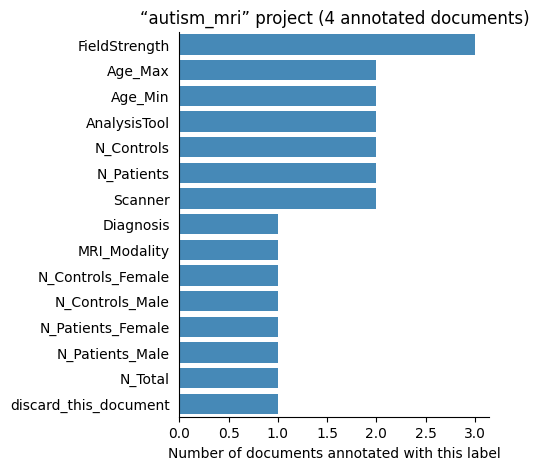

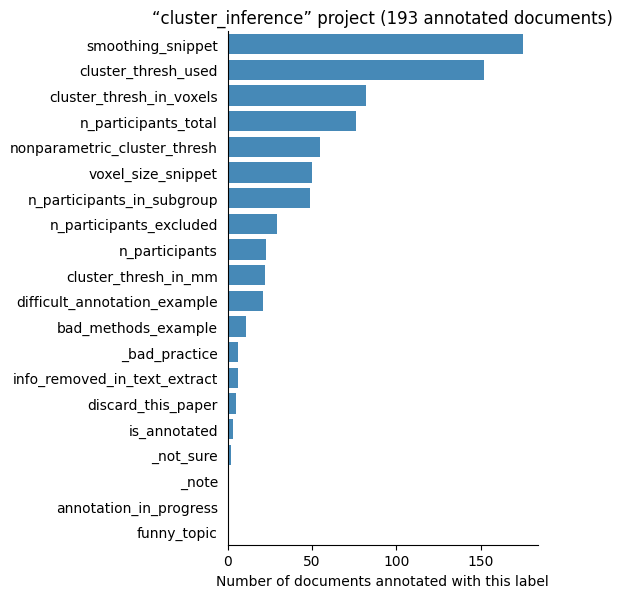

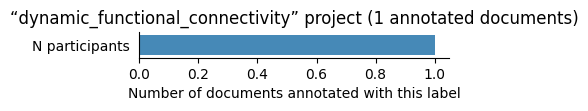

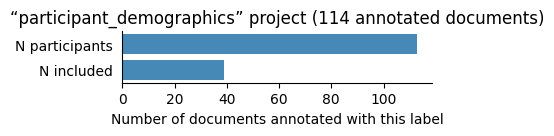

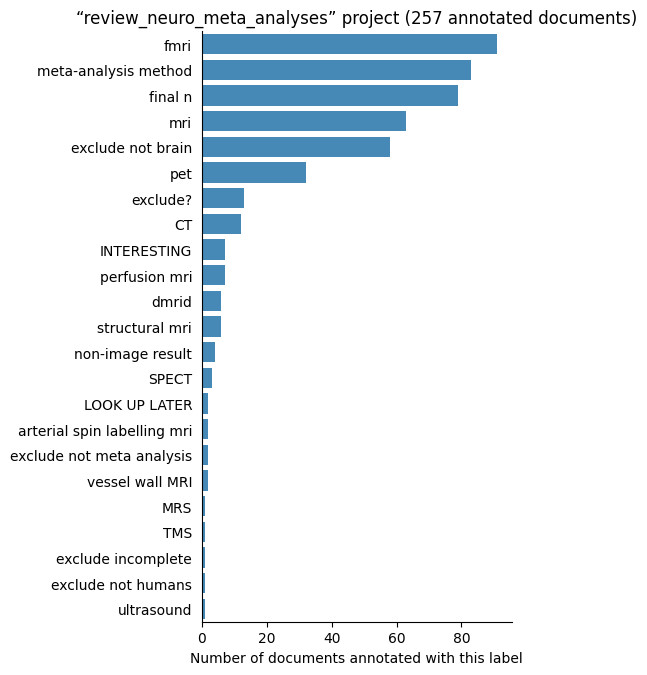

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns

projects = label_counts.groupby("project")

for project_name, data in projects:
    fig, ax = plt.subplots(figsize=(4, data.shape[0] / 3))
    sns.barplot(
        data=data, x="n_docs", y="label_name", ax=ax, color="#0071BC", alpha=.8
    )
    ax.yaxis.set_tick_params(left=False)
    ax.set_title(
        f'“{project_name}” project ({project_counts[project_name]} annotated documents)'
    )
    ax.set_ylabel("")
    ax.set_xlabel("Number of documents annotated with this label")
    sns.despine()